OCR로 영양제 표지의 글자들을 인식해서 어떤 영양제인지 예상되는 결과를 반환, 해당하는 영양제를 유저가 재확인 후 선택, 영양제의 정보, 복용법, 주의 사항 등을 보여주고, 같이 먹으면 좋은 영양제와 안좋은 영양제 제시를 위한 영양제 인식 시스템을 만든다고 가정할 때, OCR 기술이 유사한 영양제들을 탐색하는 것에 유용할 것이라 판단하고 해당 서비스를 위해 적절한 모듈을 탐색을 진행.

In [1]:
import matplotlib.pyplot as plt
import keras_ocr
import os
import cv2
import numpy as np

import pytesseract
from pytesseract import Output
from PIL import Image

# 검증용 데이터셋 준비

In [2]:
img_path = os.getenv('HOME') + '/aiffel/ocr_project/cover/'
img_list = os.listdir(img_path)
img_list = [img for img in img_list if img.endswith(".png")]
print(img_list)

images = [keras_ocr.tools.read(img_path + name) for name in img_list]
for img in images:
    print(img.shape)
#for i in img_list:
#    img = cv2.imread(img_path + i)
#    print(img.shape)
#    img_array = np.array(img)
#    images.append(img_array)

['multivitamin.png', 'coq10.png', 'wheyprotein.png', 'omega800.png', 'lglutamine.png', 'milkthistle.png', 'nattoserra.png']
(4032, 2268, 3)
(4032, 2268, 3)
(4032, 2268, 3)
(4032, 2268, 3)
(4032, 2268, 3)
(4032, 2268, 3)
(4032, 2268, 3)


# keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

## Keras-ocr

In [3]:
# karas-ocr의 detector와 recognizer를 위한 모델을 자동으로 다운로드 받게 됩니다.
pipeline = keras_ocr.pipeline.Pipeline()

prediction_groups = [pipeline.recognize([img_path + image]) for image in img_list]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


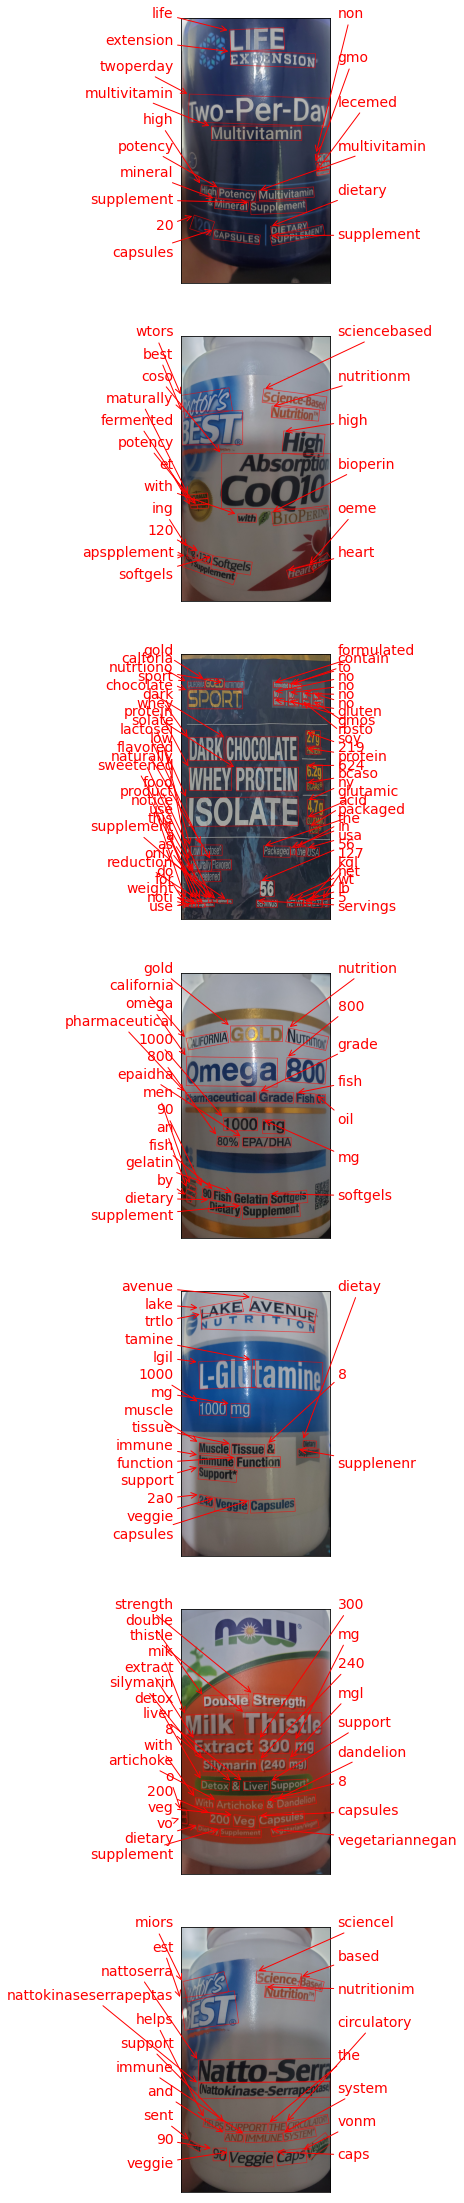

In [4]:
fig, axs = plt.subplots(nrows=len(images), figsize=(40,40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [5]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            file_name = image_path.split('/')[-1][:-4] 
            output_img_path = os.path.join(output_path, f"{file_name + '_' + str(index).zfill(4)}.png")
            
            cropped_image = image.crop((left,top,left+width,top+height))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [6]:
pytesseract_image_path_list = []

for img_l in img_list:
    img_file_path = img_path + img_l
    cropped_image_path_list = crop_word_regions(img_file_path, img_path+'output')
    pytesseract_image_path_list.append(cropped_image_path_list)

In [7]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
        image, lang='eng', config=custom_oem_psm_config, output_type=Output.DICT)
        
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        print(recognized_data['text'])
    print('-'*40)

multivitamin.png


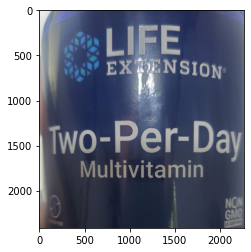

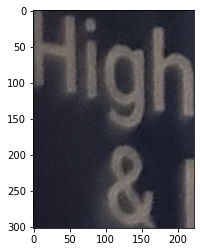

ny



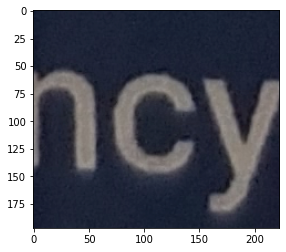

aten’



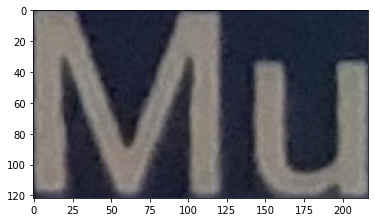

Miu



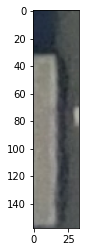

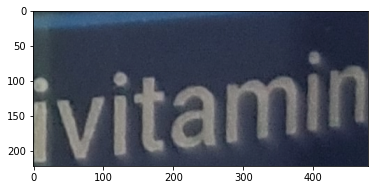

Are



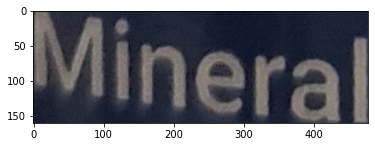

Mineral



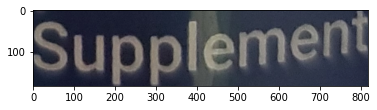

Supplement



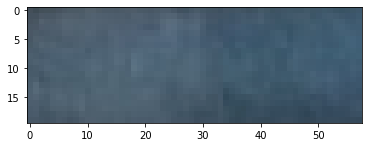

ae



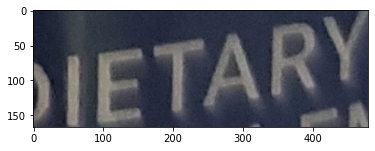

Tae



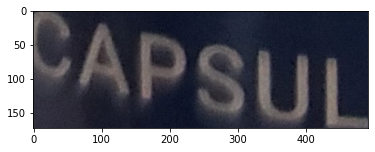

TN TSE



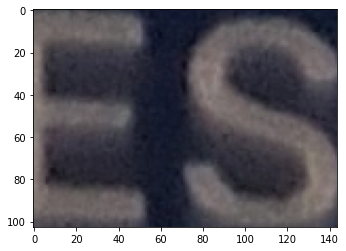

=a



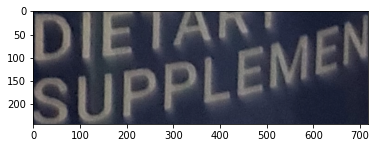

airy



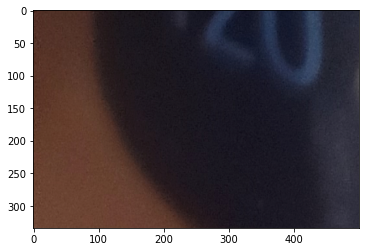

=



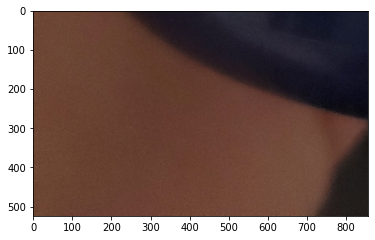

? ; .

----------------------------------------
coq10.png


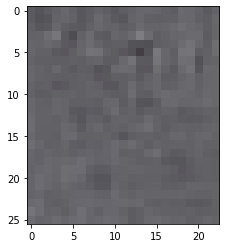

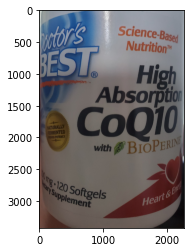


----------------------------------------
wheyprotein.png


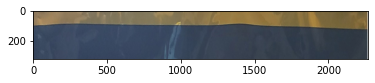

<i. / ae



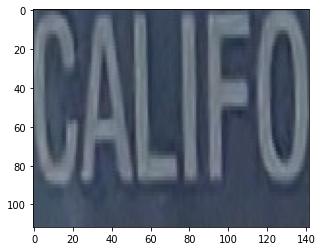

HM



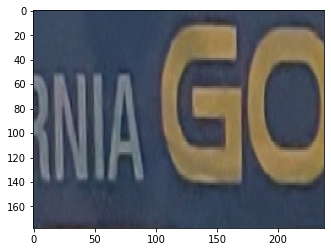

mycie



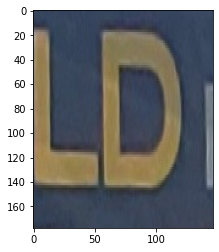

LD



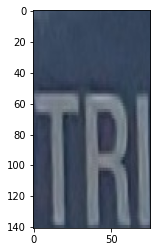

rl



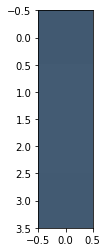

;



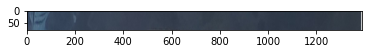

| an |



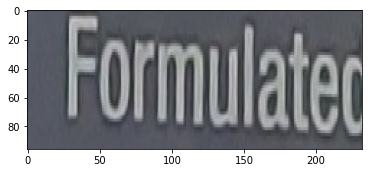

nO



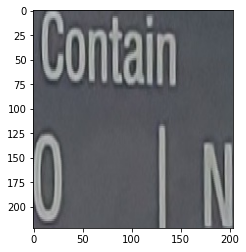

a



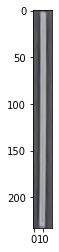

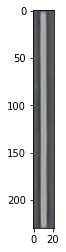

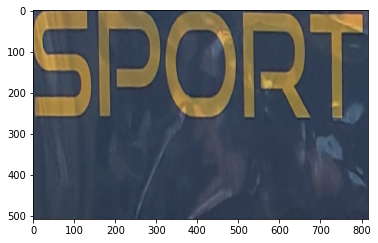

, [ n.



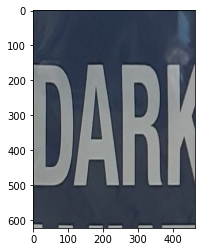

Mt



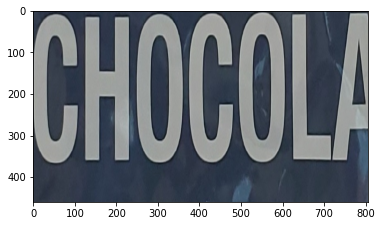

wu



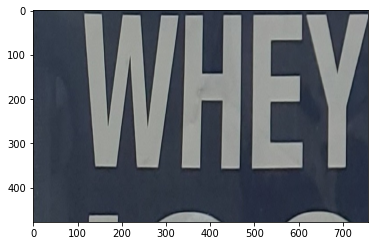

His



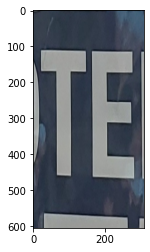

IR



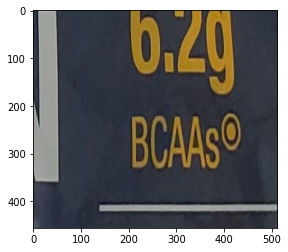

|



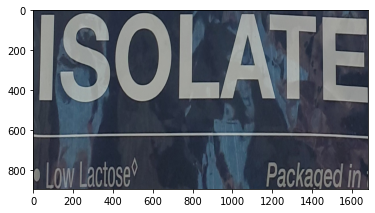

i x nis



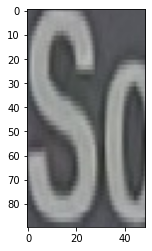

S(



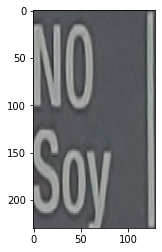

‘



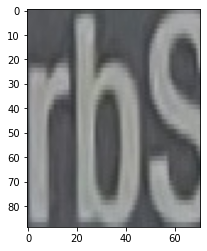

(th



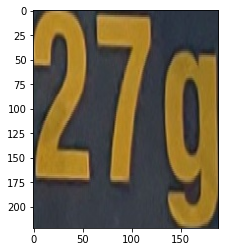

dig



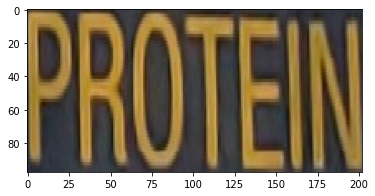

PROTEIN



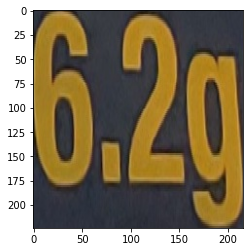

0.20



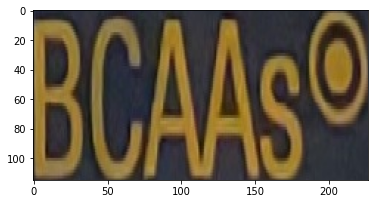

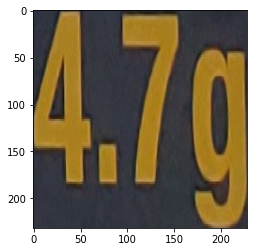

Wit



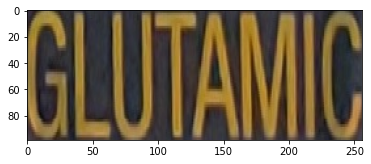

BAH



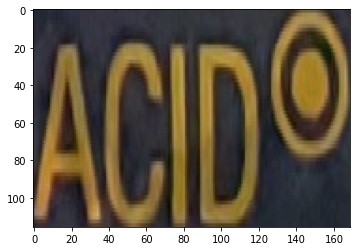

Arin®



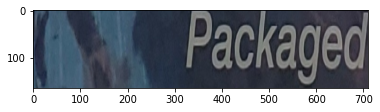

\, Packaged



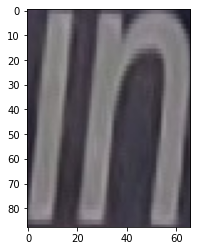

4



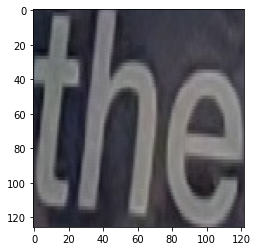

iN:



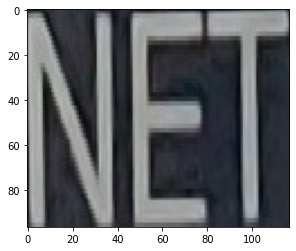

Nal



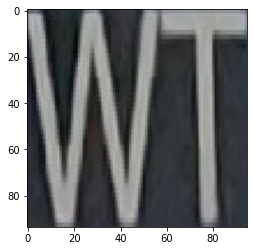

TAF



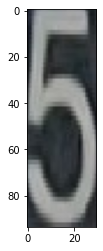

‘



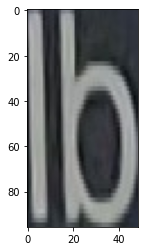

le



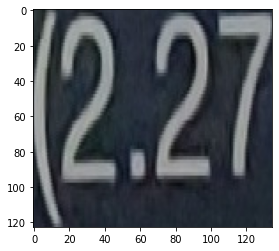

(al



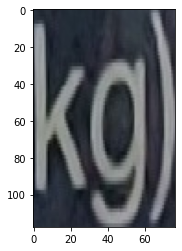

kg



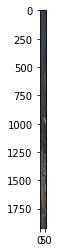


----------------------------------------
omega800.png


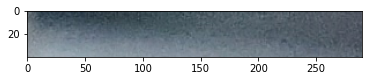

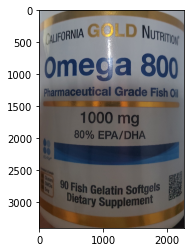

a

----------------------------------------
lglutamine.png


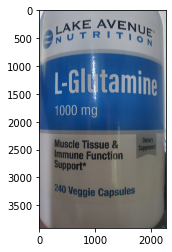


----------------------------------------
milkthistle.png


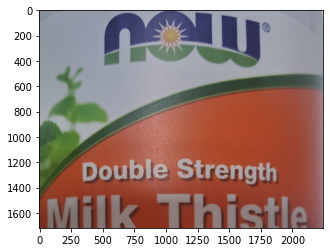

i | Aa



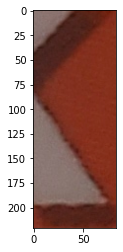

¢



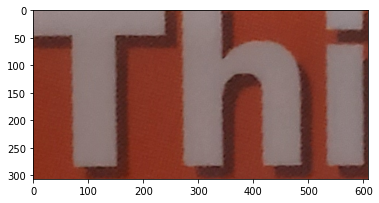

ni



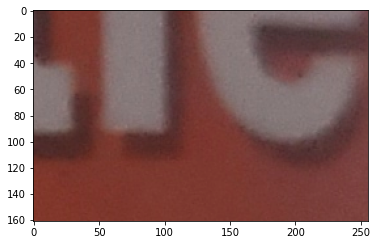

hd



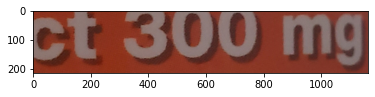

oy re) 0) Oe rile



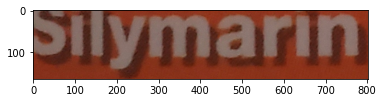

Jil ig ie)



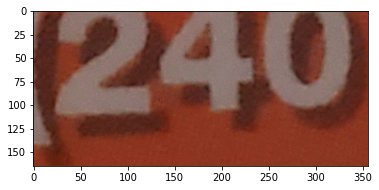

na



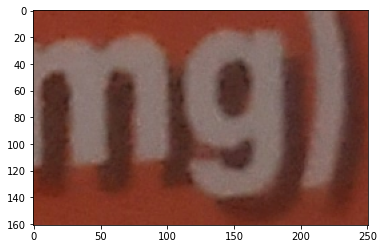

mg}



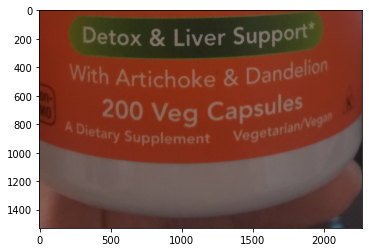


----------------------------------------
nattoserra.png


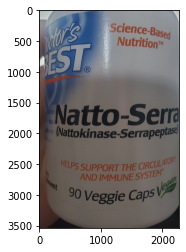


----------------------------------------


In [8]:
for idx, cropped_image_path_list in enumerate(pytesseract_image_path_list):
    print(img_list[idx])
    print('='*40)
    recognize_images(cropped_image_path_list)

# 테스트 결과 정리

|모듈이름|모델 이름|인식 단어 수|맞춘 단어 수|정확도|
|:---|:---|---:|---:|---:|
|**keras_ocr**|multivitamin|16|14|0.875|
||coq10|18|10|0.555|
||wheyprotein|59|43|0.728|
||omega800|22|18|0.818|
||lglutamine|18|14|0.777|
||milkthistle|26|21|0.807|
||nattoserra|19|13|0.684|
|**pytesseract**|multivitamin|15|2|0.133|
||coq10|2|0|0.0|
||wheyprotein|37|3|0.081|
||omega800|2|0|0.0|
||lglutamine|1|0|0.0|
||milkthistle|9|0|0.0|
||nattoserra|1|0|0.0|

# 결과 분석과 결론 제시

### 서비스 목적
* 사람들의 건강을 위해 올바른 영양제 복용을 위한 영양제 복용 도움 서비스 개발.  

### 서비스 내용
* OCR로 영양제 표지의 글자들을 인식해서 어떤 영양제인지 예상되는 결과를 반환, 해당하는 영양제를 유저가 재확인 후 선택, 영양제의 정보, 복용법, 주의 사항 등을 보여주고, 같이 먹으면 좋은 영양제와 안좋은 영양제 제시.

### 모델 평가 기준
* 해당 서비스에 적절한 모듈을 찾기위해 문자 검출 및 검출한 문자의 정확도를 측정.
* 적합한 테스트 데이터로 여러 문자의 크기, 색깔, 휘어진 글자 등 실제 영양제 표지를 촬영 했을 때의 조건과 부합한 데이터를 선택, 테스트하기 위해 현재 복용중인 영양제의 전면 표지로 모듈의 테스트를 진행

## 결과 분석
* 전체적인 단어 검출이나 단어 정확도는 keras_ocr이 높음.
* pytesseract 는 단어가 거의 검출되지 않거나 일부 검출되는 경우 글자 인식이 거의 안됨.
* 약병 가장자리에 글자가 휘거나 글자 좌우길이가 짧아지거나, 특수문자의 경우 인식이 잘 안됨을 확인.

## 결론 제시
* 사용할 모듈로는 단어 검출도와 정확도가 높은 keras_ocr을 선택.

# 회고

* keras_ocr과 tesseract의 인식률의 차이가 많이 차이나서 tesseract의 사용방식을 뭔가 잘못한게 아닌가 생각이 들었습니다.